# New York Stock Exchange Data

## Time series analysis 

### Here, we try to predict the 'close' prices of Apple stocks using traditional ARIMA and LSTM models

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import math, time
import itertools
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [2]:
data_df =  pd.read_csv("stock_prices.csv", index_col = 0)
data_df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


## Only Apple stocks (AAPL) are extracted

In [3]:
data_df = data_df[data_df.symbol == 'AAPL']
data_df.drop(['symbol'],1,inplace=True)
data_df.head()

,open,close,low,high,volume
date,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0


In [4]:
data_df.shape

(1762, 5)

In [5]:
data_df.tail()

,open,close,low,high,volume
date,,,,,
2016-12-23,115.589996,116.519997,115.589996,116.519997,14249500.0
2016-12-27,116.519997,117.260002,116.489998,117.800003,18296900.0
2016-12-28,117.519997,116.760002,116.199997,118.019997,20905900.0
2016-12-29,116.449997,116.730003,116.400002,117.110001,15039500.0
2016-12-30,116.650002,115.820000,115.430000,117.199997,30586300.0


## Visualization of Close prices of Apple Stocks

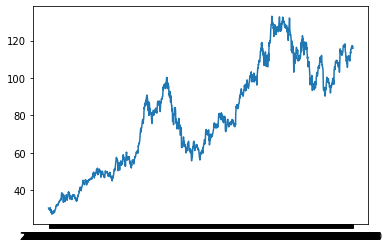

In [6]:
plt.plot(data_df['close'])
plt.show()

In [7]:
data_df['date'] = data_df.index
data_df.head()

,open,close,low,high,volume,date
date,,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0,2010-01-04
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0,2010-01-05
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0,2010-01-06
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0,2010-01-07
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0,2010-01-08


In [8]:
data_df['date'] = pd.to_datetime(data_df['date'])

In [9]:
data_df.head()

,open,close,low,high,volume,date
date,,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0,2010-01-04
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0,2010-01-05
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0,2010-01-06
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0,2010-01-07
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0,2010-01-08


## Normalization of Close price values

In [10]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data_df['close'].values.reshape(-1, 1))

In [11]:
dataset[0:10]

array([[0.02971784],
       [0.03021854],
       [0.02560389],
       [0.02507612],
       [0.0269707 ],
       [0.02444008],
       [0.02120576],
       [0.02517085],
       [0.02351986],
       [0.0187834 ]])

In [12]:
print('Dataset size', len(data_df))

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print('Train Size -', len(train),'\nTest Size -',len(test))

Dataset size 1762
Train Size - 1233 
Test Size - 529


#### Look back date is set as 15 days, which is the number of previous time steps to use as input variables to predict the next time period

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
look_back = 15

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1217, 15)
(1217,)
(513, 15)
(513,)


#### The LSTM network expects the input data (X) to be provided in the form of: [samples, time steps, features].

In [16]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1217, 15, 1)
(1217,)
(513, 15, 1)
(513,)


**LSTM**

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

* Forget Gate: conditionally decides what information to throw away from the block.
* Input Gate: conditionally decides which values from the input to update the memory state.
* Output Gate: conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

> The network is trained for 20 epochs and a batch size of 1 is used.

In [18]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(20, activation = 'relu', return_sequences = True, input_shape=(look_back, 1)))     
model.add(LSTM(20))                                  # output shape = (batch_size,20) - last hidden state shape
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
1217/1217 - 13s - loss: 0.0030
Epoch 2/20
1217/1217 - 13s - loss: 8.5870e-04
Epoch 3/20
1217/1217 - 13s - loss: 7.1039e-04
Epoch 4/20
1217/1217 - 13s - loss: 5.3697e-04
Epoch 5/20
1217/1217 - 14s - loss: 4.6468e-04
Epoch 6/20
1217/1217 - 14s - loss: 3.5079e-04
Epoch 7/20
1217/1217 - 15s - loss: 3.0886e-04
Epoch 8/20
1217/1217 - 14s - loss: 2.7181e-04
Epoch 9/20
1217/1217 - 13s - loss: 2.9932e-04
Epoch 10/20
1217/1217 - 13s - loss: 2.3132e-04
Epoch 11/20
1217/1217 - 13s - loss: 2.1922e-04
Epoch 12/20
1217/1217 - 13s - loss: 2.0646e-04
Epoch 13/20
1217/1217 - 14s - loss: 2.2941e-04
Epoch 14/20
1217/1217 - 13s - loss: 1.9193e-04
Epoch 15/20
1217/1217 - 13s - loss: 2.0982e-04
Epoch 16/20
1217/1217 - 13s - loss: 2.0191e-04
Epoch 17/20
1217/1217 - 13s - loss: 1.9732e-04
Epoch 18/20
1217/1217 - 13s - loss: 1.9488e-04
Epoch 19/20
1217/1217 - 13s - loss: 1.7663e-04
Epoch 20/20
1217/1217 - 13s - loss: 1.8096e-04


In [19]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.85 RMSE
Test Score: 3.57 RMSE


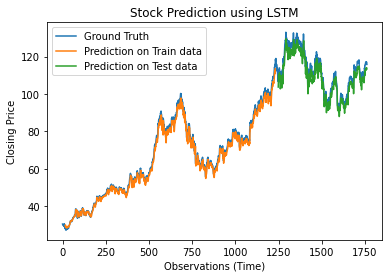

In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset), label ='Ground Truth')
plt.plot(trainPredictPlot, label ='Prediction on Train data')
plt.plot(testPredictPlot, label ='Prediction on Test data')

plt.xlabel('Observations (Time)')
plt.ylabel('Closing Price')
plt.title('Stock Prediction using LSTM')
plt.legend()
plt.show()

### Now, let's try to visualize only test predictions

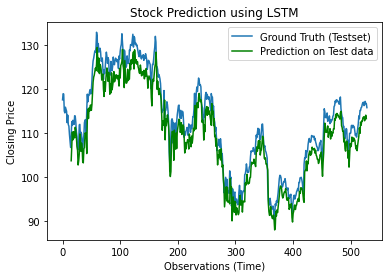

In [22]:
plt.plot(min_max_scaler.inverse_transform(test), label ='Ground Truth (Testset)')

testPredictPlot = np.empty_like(test)
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back:len(testPredict)+look_back, :] = testPredict

plt.plot(testPredictPlot, label ='Prediction on Test data', color ='g')

plt.xlabel('Observations (Time)')
plt.ylabel('Closing Price')
plt.title('Stock Prediction using LSTM')
plt.legend()
plt.show()